# The SVHN dataset preprocessing


In this notebook, we preprocess SVHN dataset of format 2 (containing 32 by 32 images) 



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


## Preprocessing Steps
### Laoding dataset

We have stored the dataset (.mat files) in the drive. So, we first load the data using  Format and we can use ``loadmat`` from ``scipy.io``

In [3]:
from scipy.io import loadmat

# Path to train_32x32.mat
PATH = '/content/drive/My Drive/Colab Notebooks/ComputerVision/HW3/Data/Data_format2/train_32x32.mat'
data_mat = loadmat(PATH)
X_train0 = data_mat['X']
y_train0 = data_mat['y']

# Path to extra_32x32.mat
PATH = '/content/drive/My Drive/Colab Notebooks/ComputerVision/HW3/Data/Data_format2/extra_32x32.mat'
data_mat = loadmat(PATH)
X_extra0 = data_mat['X']
y_extra0 = data_mat['y']

# Path to test_32x32.mat
PATH = '/content/drive/My Drive/Colab Notebooks/ComputerVision/HW3/Data/Data_format2/test_32x32.mat'
data_mat = loadmat(PATH)
X_test0 = data_mat['X']
y_test0 = data_mat['y']

# Transpose the image arrays (to be in the order of N_train, img_h, img_w , n_channels)
X_train0 = np.transpose(X_train0,(3,0,1,2))
X_test0 = np.transpose(X_test0,(3,0,1,2))
X_extra0 = np.transpose(X_extra0,(3,0,1,2))


print("data training", X_train0.shape, y_train0.shape)
print("data test", X_test0.shape, y_test0.shape)
print('data extra', X_extra0.shape, y_extra0.shape)


data training (73257, 32, 32, 3) (73257, 1)
data test (26032, 32, 32, 3) (26032, 1)
data extra (531131, 32, 32, 3) (531131, 1)


Helper function to plot sample images from each data set.

In [0]:
import pdb

In [0]:
def plot_images(X, y, nrows, ncols):

  fig, axes = plt.subplots(nrows, ncols, figsize = (12,4))

  for i, ax in enumerate(axes.flat):     

    if X[i].shape[-1] == 1:
        ax.imshow(X[i,:,:,0], 'gray')          
    else:
        ax.imshow(X[i])

    if len(y[i,:])>1:
      title = str(np.argmax(y[i,:]))
    else:
      title = str(y[i])


    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)
    ax.set_title(title)
        

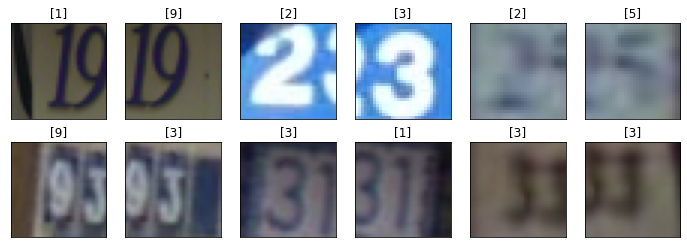

In [6]:
# Plot training images
plot_images(X_train0, y_train0, 2, 6)

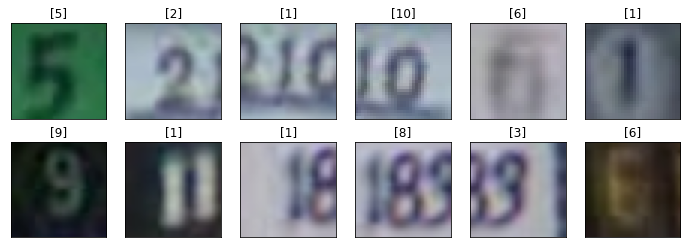

In [7]:
# Plot test images
plot_images(X_test0, y_test0, 2, 6)

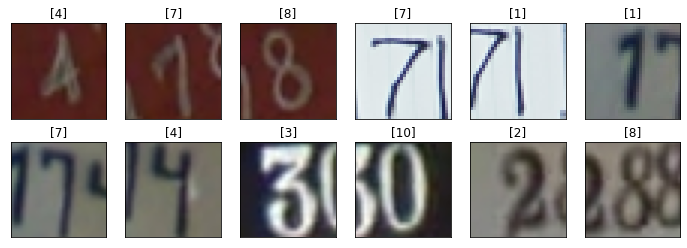

In [8]:
# Plot extra images
plot_images(X_extra0, y_extra0, 2, 6)

### Label change
Now change the label of zeros from ``10`` to ``0``. This makes indexing much easier (index = label)

In [9]:
labels = np.unique(y_train0)
n_classes = len(labels)
print(labels)

[ 1  2  3  4  5  6  7  8  9 10]


In [0]:
y_train0[y_train0 == 10] = 0
y_test0[y_test0 == 10] = 0
y_extra0[y_extra0 == 10] = 0

### Combining datasets

No we combine extra and training datasets to produce a larger training set as well a validation set.

In [11]:
X_all = np.concatenate([X_train0, X_extra0])
y_all = np.concatenate([y_train0, y_extra0])

n_total = X_all.shape[0]
print('total number of images:', n_total)

total number of images: 604388


In [0]:
shuffle_idx = np.random.choice(np.arange(n_total), n_total, replace=False)

# keep the first 580000 samples as training and the next 20000 as validation
X_train = np.copy(X_all[shuffle_idx[:580000]])
y_train = np.copy(y_all[shuffle_idx[:580000]])

X_val = np.copy(X_all[shuffle_idx[580000:600000]])
y_val = np.copy(y_all[shuffle_idx[580000:600000]])

X_test, y_test = X_test0, y_test0

### RGB to Grayscale

Now convert RGB images with channel size of 3 to grasscale (channel size 1)

In [0]:
def rgb2gray(images):
    shape = images.shape
    images_gray = np.zeros((shape[0],shape[1],shape[2],1), dtype = 'float32')
    for i,img in enumerate(images):
      images_gray[i,:] = np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),axis=2)
    return images_gray

In [0]:
# covert the images to grayscale
X_train_gray = rgb2gray(X_train)
X_test_gray = rgb2gray(X_test)
X_val_gray = rgb2gray(X_val)


### One Hot Encoding

Finally we apply One Hot Encoding to our label values.

In [15]:
from sklearn.preprocessing import OneHotEncoder
 
# OneHotEncoder
enc = OneHotEncoder().fit(y_train)

y_train = enc.transform(y_train).toarray()
y_test = enc.transform(y_test).toarray()
y_val = enc.transform(y_val).toarray()

print("training set", y_train.shape)
print("test set", y_test.shape)
print("validation set", y_val.shape)


training set (580000, 10)
test set (26032, 10)
validation set (20000, 10)


### Augmentation
Here we augment some new data by adding ratated version of current images

In [0]:
from skimage.transform import rotate


In [0]:
def rotate_images(images, rot_angles, mode='edge'):
  X_list = list()
  for i, angle in enumerate(rot_angles):
    X = np.zeros_like(images)
    for j in range(images.shape[0]):
      X[j,:,:,0] = rotate(images[j,:,:,0], angle=angle, resize=False, mode=mode)
    X_list.append(X)
  return X_list


In [0]:
degrees = [-45, 45]
X_train_rot_list = rotate_images(X_train_gray, degrees)


Now plot some sample training images as well as rotated ones

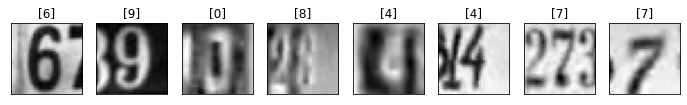

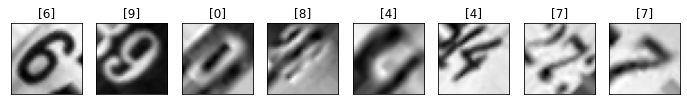

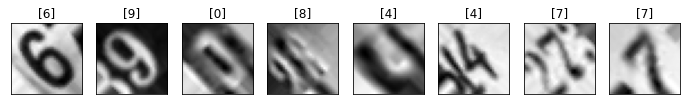

In [0]:
plot_images(X_train_gray, y_train, 1, 8)
plot_images(X_train_rot_list[0], y_train, 1, 8)
plot_images(X_train_rot_list[1], y_train, 1, 8)


In [0]:
X_train_gray = np.vstack( (X_train_gray, X_train_rot_list[0], X_train_rot_list[1]) )
y_train = np.vstack( (y_train, y_train, y_train) )

## Saving the processes dataset

Now, we save the dataset using ``pcikle`` module

In [0]:
import pickle

filename = 'SVHN_gray.pickle'

if not os.path.exists('/content/SVHN_gray.pickle'):
  try:
    pickle_file = open(filename, 'wb')
    data = {
      'X_train': X_train_gray,
      'y_train': y_train,
      'X_val': X_val_gray,
      'y_val': y_val,
      'X_test': X_test_gray,
      'y_test': y_test,
      }
    pickle.dump(data, pickle_file, pickle.HIGHEST_PROTOCOL)
    pickle_file.close()
  except Exception as e:
    print('Unable to save data to', filename, ':', e)
    raise
    


In [24]:
statinfo = os.stat(filename)
print('Pickle file size:', statinfo.st_size, 'bytes')

Pickle file size: 2614310125 bytes


Copy the dataset to drive

In [0]:
!cp  'SVHN_gray.pickle' '/content/drive/My Drive/Colab Notebooks/ComputerVision/HW3/Preprocessed/Data_format2/SVHN_gray.pickle'